[ 1.00000000 +0.00000000e+00j  0.91354546 -4.06736643e-01j
  0.30901699 -9.51056516e-01j -0.80901699 -5.87785252e-01j
 -0.50000000 +8.66025404e-01j  1.00000000 +1.13310778e-15j
 -0.80901699 -5.87785252e-01j  0.66913061 +7.43144825e-01j
 -0.80901699 -5.87785252e-01j  1.00000000 +7.34788079e-16j
 -0.50000000 +8.66025404e-01j -0.80901699 -5.87785252e-01j
  0.30901699 -9.51056516e-01j  0.91354546 -4.06736643e-01j
  1.00000000 +1.71450552e-15j]


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: ComplexWarning: Casting complex values to real discards the imaginary part
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: ComplexWarning: Casting complex values to real discards the imaginary part


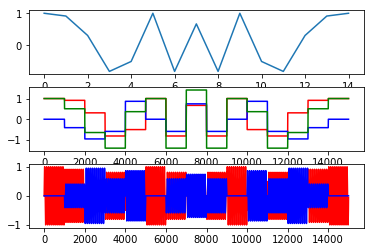

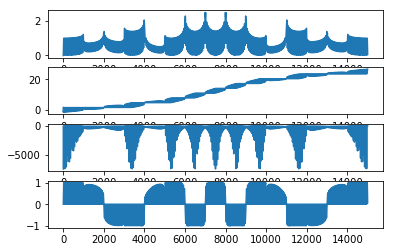

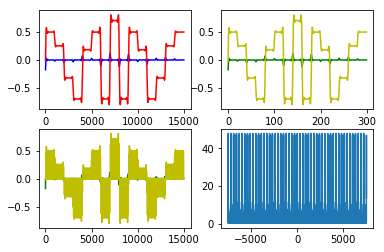

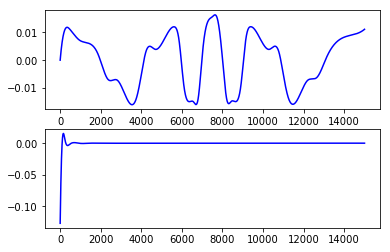

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import signalgeneration as sig
from scipy.signal import hilbert, remez, lfilter, filtfilt, decimate, butter
from scipy.interpolate import UnivariateSpline

fc = 150.0
modulation_index = 1.0
fs = 15000.0
sample_period = 1/fs
ZC_N = 15
fbw = 25
zcsig = sig.generateZCSample(ZC_N ,1)
print (zcsig)

time = np.arange(fs) / fs

carrier = np.cos(2.0 * np.pi * fc * time)
real_modulator = np.zeros_like(carrier).astype("complex64")
real_product = np.zeros_like(carrier)
imag_modulator = np.zeros_like(carrier).astype("complex64")
imag_product = np.zeros_like(carrier)
product = np.zeros_like(carrier)
# Uspsample
for i, t in enumerate(time):
    x = np.int(i/(fs/ZC_N))
    real_modulator[i] = zcsig.real[x]
    imag_modulator[i] = zcsig.imag[x]
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(zcsig)
plt.subplot(3, 1, 2)
plt.plot(real_modulator,'r')
plt.plot(imag_modulator,'b')
plt.plot(real_modulator + imag_modulator,'g')
for i, t in enumerate(time):
    # real_product[i] = np.cos((2.0 * np.pi * (fc+(imag_modulator[i]*fbw)) * t))* real_modulator[i] ##kinda works, real AM, imag FM, can be recovered
    real_product[i] = np.sin((2.0 * np.pi * fc * t))* real_modulator[i]
    imag_product[i] = np.sin((2.0 * np.pi * fc * t))* imag_modulator[i]
plt.subplot(3, 1, 3)
#plt.plot(carrier,'b')
plt.plot(real_product,'r')
plt.plot(imag_product,'b')


freqs = np.fft.fftfreq(real_product.size, (1/fs))
idx = np.argsort(freqs)

##plt.figure()
##plt.subplot(2,2,1)
##plt.plot (real_product)
##plt.subplot(2,2,2)
##plt.plot (imag_product)
##plt.subplot(2,2,3)
##plt.plot (freqs[idx],np.abs(np.fft.fft(real_product))[idx])
##plt.subplot(2,2,4)
##plt.plot (freqs[idx],np.abs(np.fft.fft(imag_product))[idx])

product = (real_product + imag_product)

##for i, t in enumerate(time):
##    x = np.int(i/(fs/ZC_N))
##    product[i] = zcsig[x]  * np.exp(-1j*2*np.pi*(fc)*t)
##    
##product_demod = product * np.exp(-1j*2*np.pi*(fc)*time)

real_result = (np.cos((2.0 * np.pi * (fc) * time)) * product) 
imag_result = np.sin((2.0 * np.pi * (fc) * time)) * product
product_demod = real_result + 1j*imag_result

z = hilbert(imag_result)
zr= z
inst_ampl = np.abs(zr)
inst_phase = np.unwrap(np.angle(zr))
inst_freq = np.diff(inst_phase)/(2*np.pi)*fs
plt.figure()
plt.subplot(4, 1, 1)
plt.plot(inst_ampl)
plt.subplot(4, 1, 2)
plt.plot(inst_phase)
plt.subplot(4, 1,3)
plt.plot(inst_freq - fc)
plt.subplot(4, 1, 4)
plt.plot(np.cos(inst_phase))
##plt.figure()
##plt.subplot(2,3,1)
##plt.plot (real_result)
##plt.subplot(2,3,2)
##plt.plot (imag_result)
##plt.subplot(2,3,4)
##plt.plot (freqs[idx],np.abs(np.fft.fft(real_result))[idx])
##plt.subplot(2,3,5)
##plt.plot (freqs[idx],np.abs(np.fft.fft(imag_result))[idx])
##plt.subplot(2,3,3)
##plt.plot (product_demod.real,'b')
##plt.plot (product_demod.imag,'r')
##plt.subplot(2,3,6)
##plt.plot (freqs[idx],np.abs(np.fft.fft(product_demod))[idx])

#lpfr = remez(64, [0,fbw,fbw+(fs/2 - fbw)/4, fs/2], [1,0], Hz=fs)

b,a = butter(4,(fc/fs),'low')
zi = filtfilt(b,a,product_demod)

##plt.figure()
##plt.subplot(2, 1, 1)
##plt.plot(zi.real,'b')
##plt.plot(-zi.imag,'r')
##plt.subplot(2, 1, 2)
##plt.plot (freqs[idx],np.abs(np.fft.fft(product_demod))[idx],'r')
##plt.plot(freqs[idx],np.abs(np.fft.fft(zi))[idx])

fs_new = int(np.ceil(fs / (2*fc)))
decimated_sig = zi[::fs_new]

plt.figure()
plt.subplot(2, 2, 1)
plt.plot(zi.real,'b')
plt.plot(zi.imag,'r')
plt.subplot(2, 2, 2)
plt.plot(decimated_sig.real,'g')
plt.plot(decimated_sig.imag,'y')
zero_pad = np.zeros(fs_new*len(decimated_sig)).astype("complex64")
zero_pad[::fs_new] = decimated_sig
plt.subplot(2, 2, 3)
plt.plot(zero_pad.real,'g')
plt.plot(zero_pad.imag,'y')
plt.subplot(2, 2, 4)
plt.plot(freqs[idx],np.abs(np.fft.fft(zero_pad))[idx])
lpIQ = filtfilt(b,a,zero_pad)

x = np.linspace(0,len(lpIQ),fs)
yi = lpIQ.imag
yr = lpIQ.real
spli = UnivariateSpline(x,yi)
splr = UnivariateSpline(x,yr)
xs = np.linspace(0,len(lpIQ),fs)

splr.set_smoothing_factor(0.1)
spli.set_smoothing_factor(0.1)

plt.figure()
plt.subplot(2, 1, 1)
plt.plot(xs,spli(xs),'b')
plt.subplot(2, 1, 2)
plt.plot(xs,splr(xs),'b')



##
##
##tmp = product[1::1] * np.conjugate(product[0:-1:1]);
### Record the angle of the complex difference vectors
##
####plt.figure()
####plt.subplot(2, 1, 1)
####plt.plot(tmp)
####plt.subplot(2, 1, 2)
####plt.plot(np.unwrap(np.angle(tmp)))
##
##z = hilbert(product)
##zr= z
##inst_ampl = np.abs(zr)
##inst_phase = np.angle(zr)
##inst_freq = np.diff(inst_phase)/(2*np.pi)*fs
##plt.figure()
##plt.subplot(4, 1, 1)
##plt.plot(inst_ampl)
##plt.subplot(4, 1, 2)
##plt.plot(inst_phase)
##plt.subplot(4, 1,3)
##plt.plot(inst_freq - fc)
##plt.subplot(4, 1, 4)
##plt.plot(np.cos(inst_phase))
##
##rzc = np.zeros(ZC_N)
##for k in range(ZC_N):
##    demod_block = inst_ampl[k*np.int(len(inst_ampl)/ZC_N):(1+k)*np.int(len(inst_ampl)/ZC_N)]
##    rzc[k] = np.average(demod_block)
##
##plt.figure()
##plt.plot(zcsig,'b')
##plt.plot(rzc,'r')
####z = hilbert(imag_result)
####inst_ampl = np.abs(z)
####inst_phase = np.unwrap(np.angle(z))
####inst_freq = np.diff(inst_phase)/(2*np.pi)*fs
####plt.figure()
####plt.subplot(4, 1, 1)
####plt.plot(inst_ampl)
####plt.subplot(4, 1, 2)
####plt.plot(inst_phase)
####plt.subplot(4, 1,3)
####plt.plot(inst_freq)
####plt.subplot(4, 1, 4)
####plt.plot(np.cos(inst_phase))
##
plt.show()
